In [29]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
import math
import xgboost
from sklearn.metrics import confusion_matrix, recall_score, precision_score, classification_report, f1_score, accuracy_score, mean_absolute_percentage_error

import time
from tqdm import tqdm
import keras.models
import keras.layers
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import warnings
warnings.simplefilter('ignore')

In [30]:
# Define a function to calculate the remaining useful life (RUL)
def add_rul(g):
    # Calculate the RUL as the difference between the maximum cycle value and the cycle value for each row
    g['RUL'] = max(g['Cycles']) - g['Cycles']
    return g

def plot_graphs():
    #Plot the maximum time cycle of each unit
    plt.style.use("seaborn")
    plt.figure(figsize=(10, 10))
    sns.barplot(x=list(cnt_val), y=list(cnt_ind), palette='magma')
    plt.xlabel('Number of Cycles')
    plt.ylabel('Engine Id')
    plt.title('Number of Cycles for Engines', fontweight='bold', fontsize=12, pad=15)
    plt.show()

    #Standard deviation : The spread of values from the mean
    plt.figure(figsize=(18, 9))
    subset_stats = data_train.agg(['mean', 'std']).T[2:]
    ax = sns.barplot(x=subset_stats.index, y="std", data=subset_stats, palette='magma')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_xlabel("Sensor")
    ax.set_ylabel("Standard Deviation")
    ax.set_title("Standard Deviation of Each Column", fontweight='bold', fontsize=24, pad=15)
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(),3)), (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.show()

    sns.heatmap(train.corr(),annot=True,cmap='Blues',linewidths=0.2)
    fig=plt.gcf()
    fig.set_size_inches(20,20)
    plt.show()

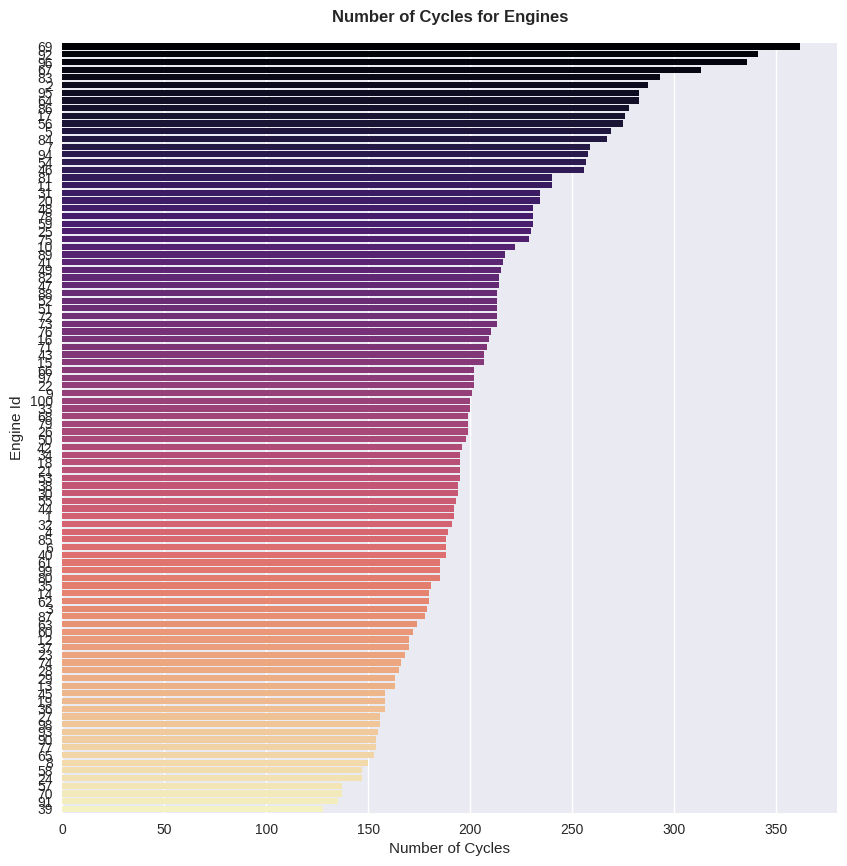

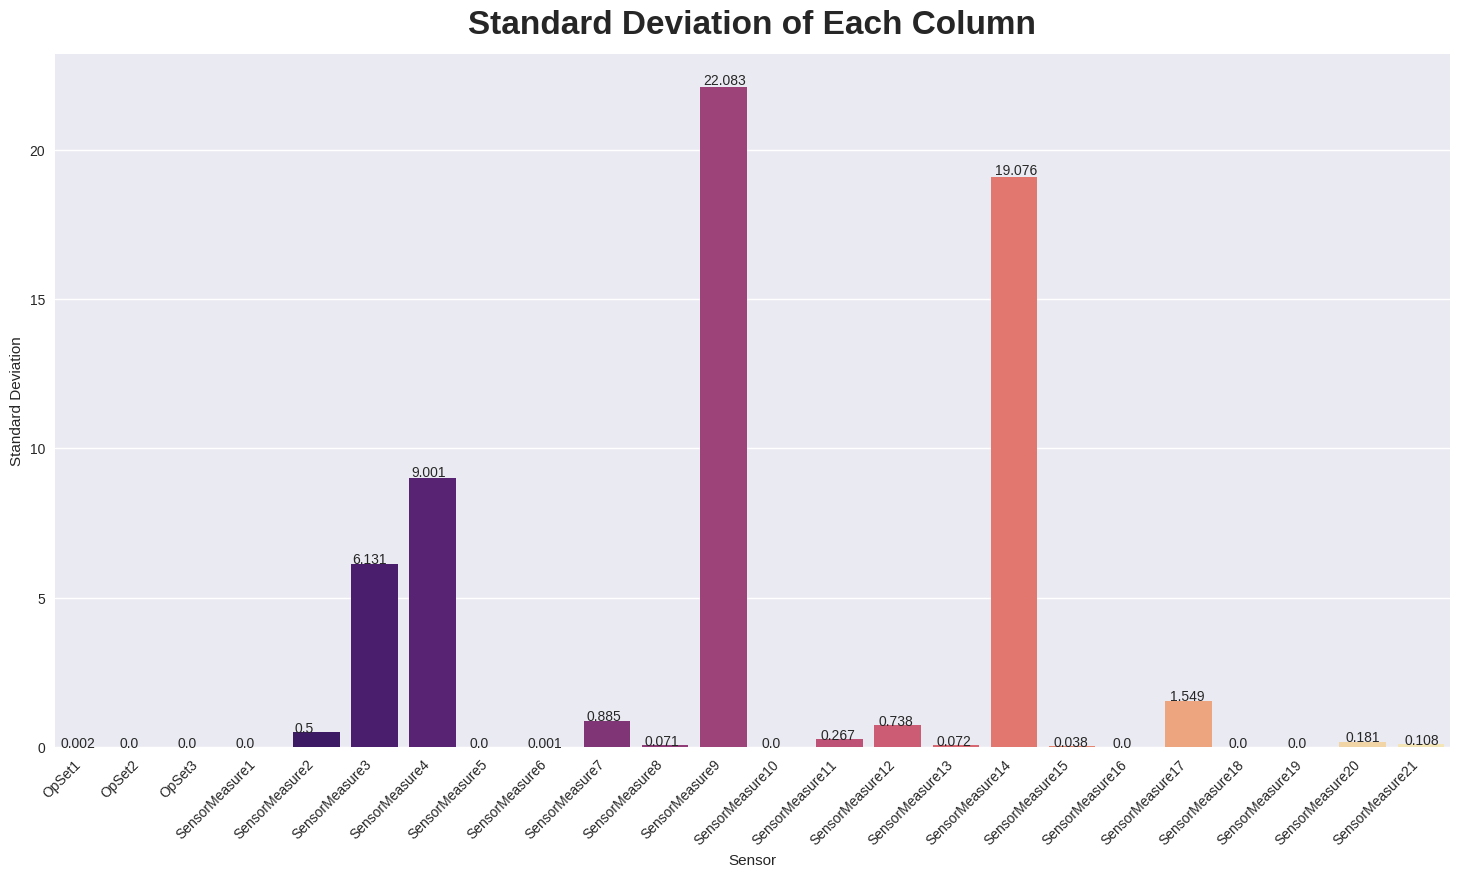

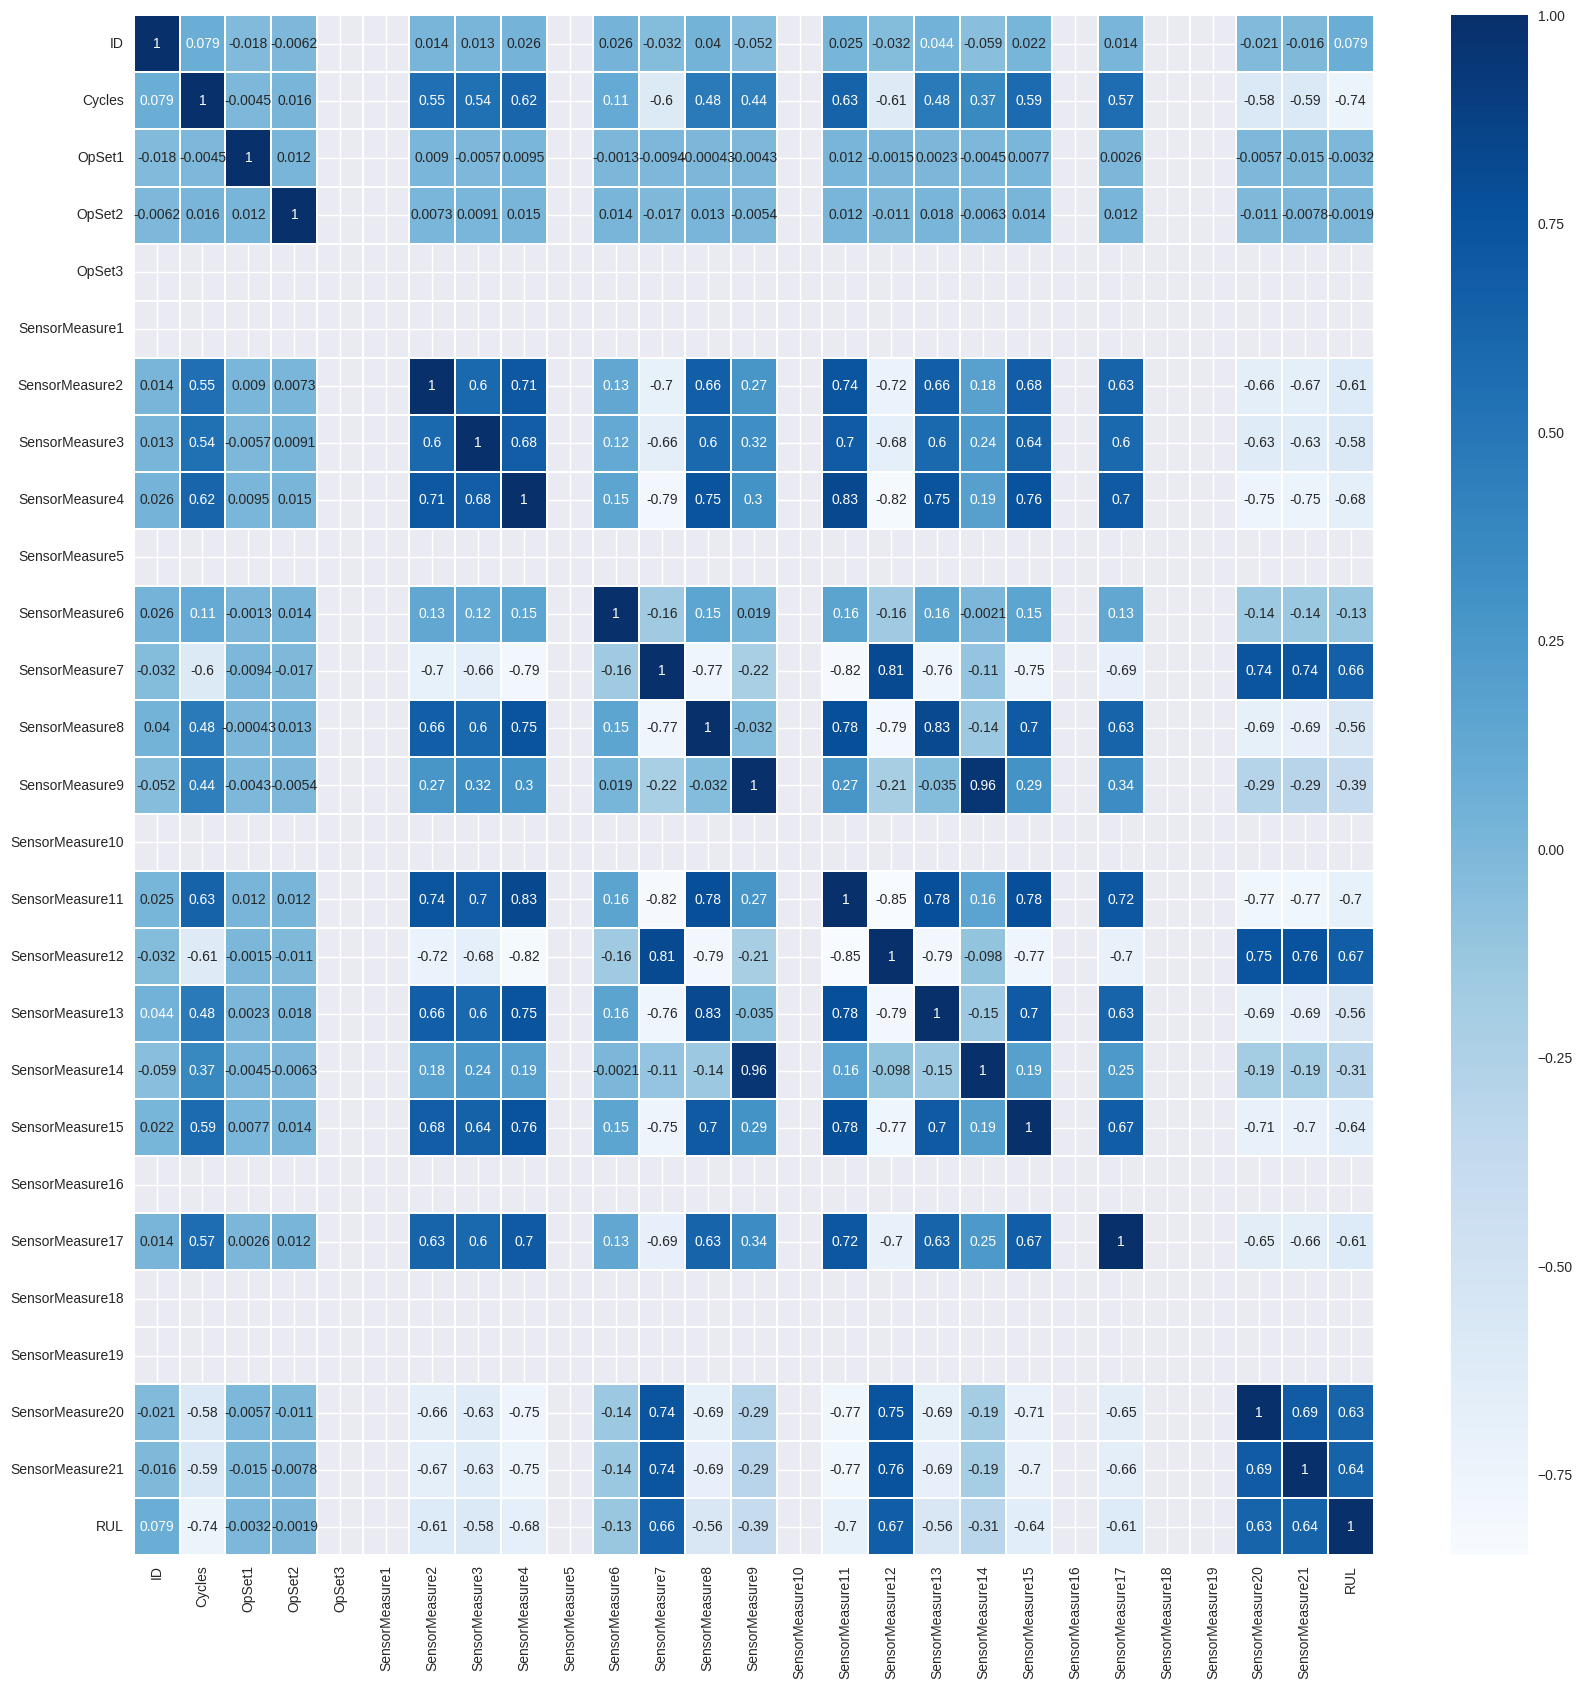

In [31]:
# Load dataset and dropping null columns
data_train = pd.read_csv("/content/train_FD001.txt",sep=" ",header=None)
data_test = pd.read_csv("/content/test_FD001.txt",sep=" ",header=None)
data_RUL = pd.read_csv("/content/RUL_FD001.txt",sep=" ",header=None)

train_copy = data_train
test_copy = data_test

#remove null columns
data_train.drop(columns=[26,27],inplace=True)
data_test.drop(columns=[26,27],inplace=True)
data_RUL.drop(columns=[1],inplace=True)

#Renaming columns
columns_train = ['ID', 'Cycles', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure1', 'SensorMeasure2', 'SensorMeasure3', 'SensorMeasure4', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure7', 'SensorMeasure8', 'SensorMeasure9', 'SensorMeasure10', 'SensorMeasure11', 'SensorMeasure12', 'SensorMeasure13', 'SensorMeasure14', 'SensorMeasure15', 'SensorMeasure16', 'SensorMeasure17', 'SensorMeasure18', 'SensorMeasure19', 'SensorMeasure20', 'SensorMeasure21']
data_train.columns = columns_train

# Apply the add_rul function to the training data grouped by the unit ID
train = data_train.groupby('ID').apply(add_rul)

#The maximum time cycle of each unit
cnt_train = train[["ID", "Cycles"]].groupby("ID").max().sort_values(by="Cycles", ascending=False)
cnt_ind = [str(i) for i in cnt_train.index.to_list()]
cnt_val = list(cnt_train.Cycles.values)

plot_graphs()

#Dropping the senors features with no spread
train.drop(columns=['SensorMeasure18','SensorMeasure19','SensorMeasure16','SensorMeasure10','SensorMeasure5','SensorMeasure1','OpSet3'],inplace=True)



- NC with a standard deviation of 22.083, suggests that the values of this variable are quite spread out from the mean.

- Some sensors have a high correlation to RUL. These are Sensors 7, 12, 20 and 21. Sensor 9 and Sensor 14 have a very high correlation to each other, but since none of them has a substatial correlation to the target, both can be dropped together with the rest of the low-correlation features.

In [32]:
#Function that return the remaining useful life (RUL) for each cycle in the input data.
#If the early_rul_duration is less than or equal to 0, then the target variable is a reversed range of data_length-1 to 0.
def process_targets(data_length, early_rul = None):
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

# If target_data is not None, the function also outputs output_targets, a numpy array with shape (num_batches,)
# containing the target values for each batch
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets


# processes the test data for a single engine in preparation for making predictions using a trained model.
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):

    max_num_test_batches = np.int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length= window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length= window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows

In [33]:
test_data = pd.read_csv("/content/test_FD001.txt", sep = "\s+", header = None,names=columns_train )
true_rul = pd.read_csv("/content/RUL_FD001.txt", sep = '\s+', header = None)

window_length = 30
shift = 1
early_rul = 125
processed_train_data = []
processed_train_targets = []
num_test_windows = 5
processed_test_data = []
num_test_windows_list = []

columns_to_be_dropped =['ID','OpSet1','OpSet2','OpSet3', 'SensorMeasure1', 'SensorMeasure5','SensorMeasure11','SensorMeasure6', 'SensorMeasure10',
                 'SensorMeasure16', 'SensorMeasure19', 'SensorMeasure18']

train_data_first_column = data_train ["ID"]
test_data_first_column = test_data["ID"]

In [34]:
# Transform and Scale the dataset using Min max scalar
scaler = StandardScaler()
train_data = scaler.fit_transform(data_train.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

**Training data process:**

In [35]:
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values

    # Determine whether it is possible to extract training data with the specified window length.
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")

    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets,
                                                                                window_length= window_length, shift = shift)

    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

**Test data process:**

In [36]:
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values

    # Determine whether it is possible to extract test data with the specified window length.
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")

    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length=window_length, shift = shift,
                                                             num_test_windows = num_test_windows)

    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

In [37]:
print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

Processed trianing data shape:  (17731, 30, 14)
Processed training ruls shape:  (17731,)
Processed test data shape:  (497, 30, 14)
True RUL shape:  (100,)


In [38]:
processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,
                                                                                                            processed_train_targets,
                                                                                                            test_size = 0.2,
                                                                                                            random_state = 83)
print("Processed train data shape: ", processed_train_data.shape)
print("Processed validation data shape: ", processed_val_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)
print("Processed validation targets shape: ", processed_val_targets.shape)

Processed train data shape:  (14184, 30, 14)
Processed validation data shape:  (3547, 30, 14)
Processed train targets shape:  (14184,)
Processed validation targets shape:  (3547,)


# **LSTM**


In [39]:
# Model training
def create_compiled_model():
    model = Sequential([
        layers.LSTM(128, input_shape = (window_length, 14), return_sequences=True, activation = "tanh"),
        layers.LSTM(64, activation = "tanh", return_sequences = True),
        layers.LSTM(32, activation = "tanh"),
        layers.Dense(96, activation = "relu"),
        layers.Dense(128, activation = "relu"),
        layers.Dense(1)
    ])
    model.compile(loss = "mse", optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'] )
    return model

# function that adjusts the learning rate during the training process,
def scheduler(epoch):
    if epoch < 5:
        return 0.001
    else:
        return 0.0001

In [40]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)
model = create_compiled_model()
history = model.fit(processed_train_data, processed_train_targets, epochs = 10,
                    validation_data = (processed_val_data, processed_val_targets),
                    callbacks = callback,
                    batch_size = 128, verbose = 2)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
111/111 - 31s - loss: 2866.7715 - accuracy: 0.0061 - val_loss: 323.3163 - val_accuracy: 0.0042 - lr: 0.0010 - 31s/epoch - 277ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
111/111 - 23s - loss: 231.5513 - accuracy: 0.0060 - val_loss: 206.8302 - val_accuracy: 0.0042 - lr: 0.0010 - 23s/epoch - 209ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
111/111 - 20s - loss: 162.9507 - accuracy: 0.0060 - val_loss: 141.9580 - val_accuracy: 0.0042 - lr: 0.0010 - 20s/epoch - 184ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
111/111 - 21s - loss: 131.2345 - accuracy: 0.0060 - val_loss: 126.2224 - val_accuracy: 0.0042 - lr: 0.0010 - 21s/epoch - 191ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/10
111/111 - 22s - loss: 110.3573 - accuracy: 0.0060 - val_loss: 111.3603 - val_accuracy: 0.0042 - 

In [41]:
#Predict on test Dats
rul_pred = model.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows))
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)
print("R-Squared Score ", r2_score(true_rul,mean_pred_for_each_engine))


16/16 [==============================] - 2s 24ms/step
RMSE:  15.15998990485358
R-Squared Score  0.8669121895971401


To compute the RMSE, we consider only the last example of each engine.

In [42]:
tf.keras.models.save_model(model, "FD001_LSTM_piecewise_RMSE_"+ str(np.round(RMSE, 4)) + ".h5")

indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)
print("Percentage error ",mean_absolute_percentage_error(true_rul, preds_for_last_example))

RMSE (Taking only last examples):  15.11799326986773
Percentage error  0.16173454469986218


A value of 15.11 indicates that the average deviation of the predictions from the actual values is around 15.30


In [43]:
#compute S-score
def compute_s_score(rul_true, rul_pred):
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)

S-score:  412.5881315929605


It is a measure of the difference between the actual and predicted RUL values normalized by the standard deviation of the RUL.
A higher S-score indicates a better prediction performance.
In general, an S-score of 412.5 indicates a good performance of the prediction model.

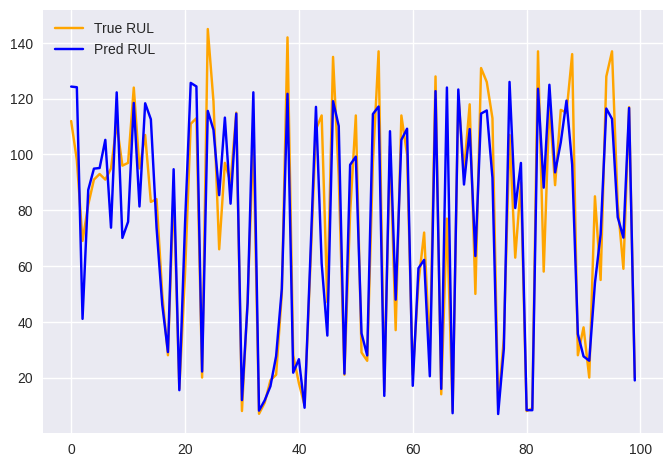

In [44]:
# Plot true and predicted RUL values
plt.plot(true_rul, label = "True RUL", color = "orange")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()

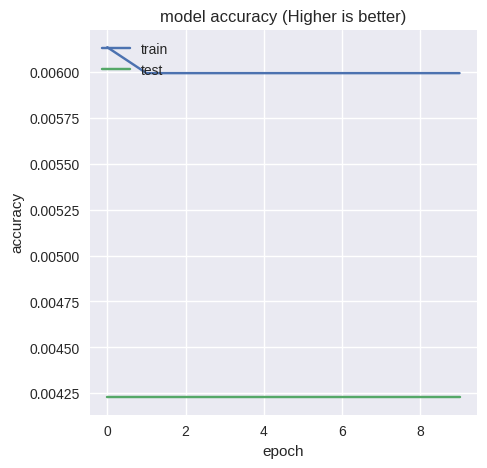

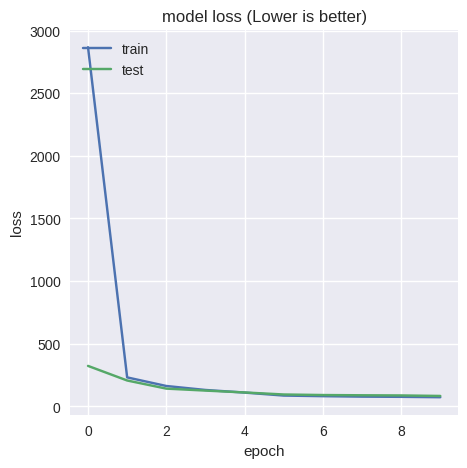

In [45]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(5, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy (Higher is better)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_accuracy.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss (Lower is better)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_loss.png")